# PCD — Klasifikasi Makanan Padang (Operasi Citra Klasik)

Pipeline berbasis operasi citra klasik untuk 9 kelas makanan Padang: segmentasi → fitur warna + tekstur → SVM.

Fitur utama:
- Segmentasi ROI makanan (threshold saturasi HSV / K-Means di Lab)
- Warna: histogram HSV + momen warna (Lab)
- Tekstur: LBP uniform multi-skala + GLCM (Haralick)
- Klasifikasi: SVM (grid search) + evaluasi k-fold / holdout
- Ablasi: warna saja, tekstur saja, gabungan, dengan/ tanpa segmentasi

Catatan: Notebook ini memfokuskan pada operasi citra untuk mata kuliah Pengolahan Citra Digital.

## Cara Pakai
- Pastikan dataset berada di folder `dataset_padang_food`, dengan struktur subfolder per kelas (mis. `dataset_padang_food/rendang`, `dataset_padang_food/ayam_goreng`, dst).
- Jalankan sel dari atas ke bawah.
- Atur konfigurasi pada sel "Konfigurasi" (segmentasi, fitur, PCA, CV).
- Gunakan sel ablation untuk membandingkan warna vs tekstur vs gabungan.

Jika beberapa paket belum terpasang, sel pertama akan mencoba meng-install otomatis.

In [16]:
# Install dependensi jika belum tersedia (opsional)
import sys, subprocess
def pip_install(pkg):
    try:
        print(f'Installing {pkg} ...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])
    except Exception as e:
        print(f'Warning: gagal install {pkg}: {e}')

# Coba import, jika gagal baru install
try:
    import numpy as np
    import cv2
    import skimage
    import sklearn
    import matplotlib
except Exception:
    pip_install('numpy')
    pip_install('opencv-python')
    pip_install('scikit-image')
    pip_install('scikit-learn')
    pip_install('matplotlib')
    pip_install('seaborn')
    pip_install('tqdm')

# Import ulang pasca install
import os, math, random, json, time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color, feature, filters, morphology, measure, exposure
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
try:
    import seaborn as sns
except Exception:
    sns = None
try:
    from tqdm import tqdm
except Exception:
    tqdm = lambda x, **kw: x

SEED = 42
random.seed(SEED); np.random.seed(SEED)

print('Versions:')
print('numpy', np.__version__)
print('cv2', cv2.__version__)
import skimage, sklearn
print('skimage', skimage.__version__)
print('sklearn', sklearn.__version__)


Versions:
numpy 1.26.4
cv2 4.11.0
skimage 0.25.2
sklearn 1.6.1


In [17]:
# Konfigurasi
dataset_dir = 'dataset_padang_food'  # ganti jika lokasi berbeda
img_size = 384                 # sisi pendek di-resize proporsional
use_segmentation = True        # gunakan segmentasi ROI makanan
segmentation_method = 'saturation'  # 'saturation' atau 'kmeans'

# Pilihan fitur
use_hist_hsv = True
use_color_moments = True
use_lbp = True
use_glcm = True
use_gabor = False  # opsional, menambah waktu komputasi

# Klasifikasi & evaluasi
use_pca = True
pca_var = 0.95
test_size = 0.2
cv_folds = 5
random_state = SEED

# LBP parameter
lbp_radii = [1, 2, 3]
lbp_points = [8, 16, 24]
lbp_method = 'uniform'

# GLCM parameter
glcm_distances = [1, 2, 3]
glcm_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm_props = ['contrast', 'homogeneity', 'energy', 'correlation', 'dissimilarity']

# Histogram HSV bin
h_bins, s_bins, v_bins = 12, 4, 4

print('Dataset dir:', os.path.abspath(dataset_dir))


Dataset dir: d:\Download\Semester 7\PCD\tubes\dataset_padang_food


Kelas: ['ayam_goreng', 'ayam_pop', 'daging_rendang', 'dendeng_batokok', 'gulai_ikan', 'gulai_tambusu', 'gulai_tunjang', 'telur_balado', 'telur_dadar']
Jumlah gambar: 993
Distribusi: Counter({'gulai_tunjang': 119, 'telur_dadar': 116, 'ayam_pop': 113, 'gulai_ikan': 111, 'telur_balado': 111, 'dendeng_batokok': 109, 'ayam_goreng': 107, 'daging_rendang': 104, 'gulai_tambusu': 103})


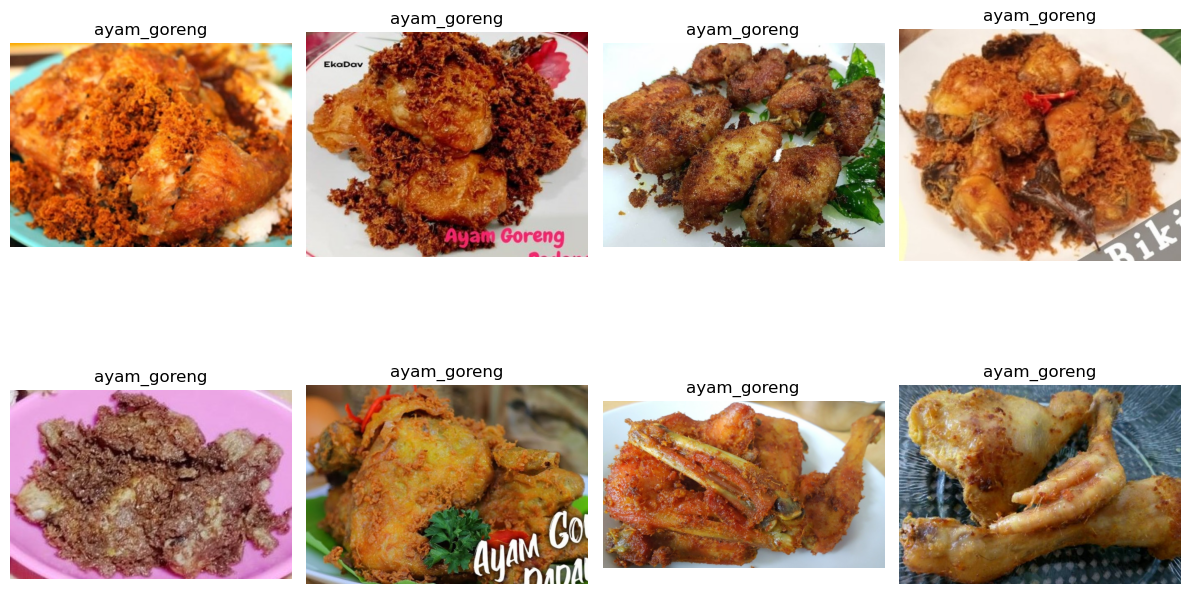

In [18]:
# Utilitas IO & tampilan
def list_image_paths(root):
    classes = []
    paths = []
    if not os.path.isdir(root):
        raise FileNotFoundError(f'Folder tidak ditemukan: {root}')
    for d in sorted(os.listdir(root)):
        dd = os.path.join(root, d)
        if os.path.isdir(dd):
            files = []
            for fn in os.listdir(dd):
                if fn.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff')):
                    files.append(os.path.join(dd, fn))
            if files:
                classes.append(d)
                for f in files:
                    paths.append((f, d))
    if not paths:
        raise RuntimeError('Tidak ada gambar ditemukan di subfolder kelas.')
    return classes, paths

def imread_resize(path, target_short=img_size):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise RuntimeError(f'Gagal membaca: {path}')
    h, w = img.shape[:2]
    short = min(h, w)
    scale = target_short / short
    nh, nw = int(round(h*scale)), int(round(w*scale))
    img = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
    return img

def show_imgs(imgs, cols=4, figsize=(12,8), titles=None):
    rows = math.ceil(len(imgs)/cols)
    plt.figure(figsize=figsize)
    for i, im in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        if im.ndim == 2:
            plt.imshow(im, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

classes, all_paths = list_image_paths(dataset_dir)
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
print('Kelas:', classes)
print('Jumlah gambar:', len(all_paths))
from collections import Counter
cnt = Counter([y for _,y in all_paths])
print('Distribusi:', cnt)
# Tampilkan beberapa sampel
samples = []
titles = []
for p,y in all_paths[:min(8, len(all_paths))]:
    samples.append(imread_resize(p))
    titles.append(y)
show_imgs(samples, cols=4, titles=titles)


In [19]:
# Color constancy dan Segmentasi
def gray_world(img_bgr):
    img = img_bgr.astype(np.float32)
    mean_bgr = img.reshape(-1,3).mean(axis=0)
    gray_val = np.mean(mean_bgr) + 1e-6
    scale = gray_val / (mean_bgr + 1e-6)
    img *= scale
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def segment_by_saturation(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    s = hsv[:,:,1]
    # Ambang berdasarkan Otsu pada S ter-normalisasi
    s_blur = cv2.GaussianBlur(s, (5,5), 0)
    _, th = cv2.threshold(s_blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask = (s > th).astype(np.uint8)
    return postprocess_mask(mask)

def segment_by_kmeans_lab(img_bgr, k=3, attempts=3):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    ab = lab[:,:,1:3].reshape(-1,2).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 40, 1.0)
    _, labels, centers = cv2.kmeans(ab, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    labels = labels.reshape(lab.shape[:2])
    # Pilih cluster dengan variansi warna paling tinggi sebagai foreground
    mask_scores = []
    for ci in range(k):
        m = (labels==ci)
        if m.sum() == 0:
            mask_scores.append((-1, ci))
            continue
        ab_ci = ab[labels.reshape(-1)==ci]
        var = ab_ci.var()
        mask_scores.append((var, ci))
    mask_scores.sort(reverse=True)
    best_ci = mask_scores[0][1] if mask_scores else 0
    mask = (labels==best_ci).astype(np.uint8)
    return postprocess_mask(mask)

def postprocess_mask(mask):
    mask = (mask>0).astype(np.uint8)
    mask = cv2.medianBlur(mask*255, 5)
    mask = (mask>0).astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    # Pilih komponen terbesar
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        areas = stats[1:, cv2.CC_STAT_AREA]
        largest = 1 + np.argmax(areas)
        mask = (labels==largest).astype(np.uint8)
    return mask

def get_mask(img_bgr, method='saturation'):
    if method == 'saturation':
        return segment_by_saturation(img_bgr)
    elif method == 'kmeans':
        return segment_by_kmeans_lab(img_bgr)
    else:
        return np.ones(img_bgr.shape[:2], dtype=np.uint8)


In [20]:
# Ekstraksi fitur
def hsv_histogram(img_bgr, mask=None, bins=(12,4,4)):
    h_bins, s_bins, v_bins = bins
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h = cv2.calcHist([hsv],[0],mask, [h_bins],[0,180])
    s = cv2.calcHist([hsv],[1],mask, [s_bins],[0,256])
    v = cv2.calcHist([hsv],[2],mask, [v_bins],[0,256])
    hist = np.concatenate([h.flatten(), s.flatten(), v.flatten()]).astype(np.float32)
    if hist.sum() > 0:
        hist /= (hist.sum()+1e-8)
    return hist

def color_moments_lab(img_bgr, mask=None):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    feats = []
    if mask is not None:
        mask_bool = mask.astype(bool)
    else:
        mask_bool = slice(None)
    for c in range(3):
        ch = lab[:,:,c]
        vals = ch[mask_bool].astype(np.float32).ravel()
        if vals.size == 0:
            vals = ch.astype(np.float32).ravel()
        mean = vals.mean()
        std = vals.std()
        skew = ((vals - mean)**3).mean() / (std**3 + 1e-8)
        feats.extend([mean, std, skew])
    return np.array(feats, dtype=np.float32)

def lbp_features(gray, mask=None, radii=[1,2,3], points=[8,16,24], method='uniform'):
    feats = []
    if mask is not None:
        mask_bool = mask.astype(bool)
    else:
        mask_bool = None
    for r, p in zip(radii, points):
        lbp = local_binary_pattern(gray, p, r, method=method)
        if method == 'uniform':
            n_bins = p + 2
        else:
            n_bins = int(lbp.max()+1)
        if mask_bool is not None:
            vals = lbp[mask_bool].ravel()
        else:
            vals = lbp.ravel()
        hist, _ = np.histogram(vals, bins=n_bins, range=(0, n_bins), density=True)
        feats.extend(hist.tolist())
    return np.array(feats, dtype=np.float32)

def glcm_features(gray, mask=None, distances=[1,2,3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], props=None):
    if props is None:
        props = ['contrast','homogeneity','energy','correlation','dissimilarity']
    # Kuantisasi ke 8-bit untuk GLCM
    img = gray
    if mask is not None:
        img = img.copy()
        img[mask==0] = 0
    img8 = exposure.rescale_intensity(img, out_range=(0,255)).astype(np.uint8)
    glcm = graycomatrix(img8, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    feats = []
    for pr in props:
        vals = graycoprops(glcm, pr).ravel()
        feats.extend([vals.mean(), vals.std()])
    return np.array(feats, dtype=np.float32)

def gabor_bank_features(gray, mask=None, n_orient=4, n_scales=3):
    feats = []
    rows, cols = gray.shape
    thetas = np.linspace(0, np.pi, n_orient, endpoint=False)
    sigmas = np.linspace(1.0, 3.0, n_scales)
    for th in thetas:
        for sg in sigmas:
            kern = cv2.getGaborKernel((21,21), sg, th, 10, 0.5, 0, ktype=cv2.CV_32F)
            resp = cv2.filter2D(gray, cv2.CV_32F, kern)
            if mask is not None:
                vals = resp[mask>0] if np.any(mask) else resp.ravel()
            else:
                vals = resp.ravel()
            feats.extend([float(np.mean(vals)), float(np.std(vals))])
    return np.array(feats, dtype=np.float32)

def extract_features(img_bgr, mask=None):
    feats = []
    if use_hist_hsv:
        feats.append(hsv_histogram(img_bgr, mask, bins=(h_bins, s_bins, v_bins)))
    if use_color_moments:
        feats.append(color_moments_lab(img_bgr, mask))
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    if use_lbp:
        feats.append(lbp_features(gray, mask, lbp_radii, lbp_points, lbp_method))
    if use_glcm:
        feats.append(glcm_features(gray, mask, glcm_distances, glcm_angles, glcm_props))
    if use_gabor:
        feats.append(gabor_bank_features(gray, mask))
    return np.concatenate(feats, axis=0).astype(np.float32)


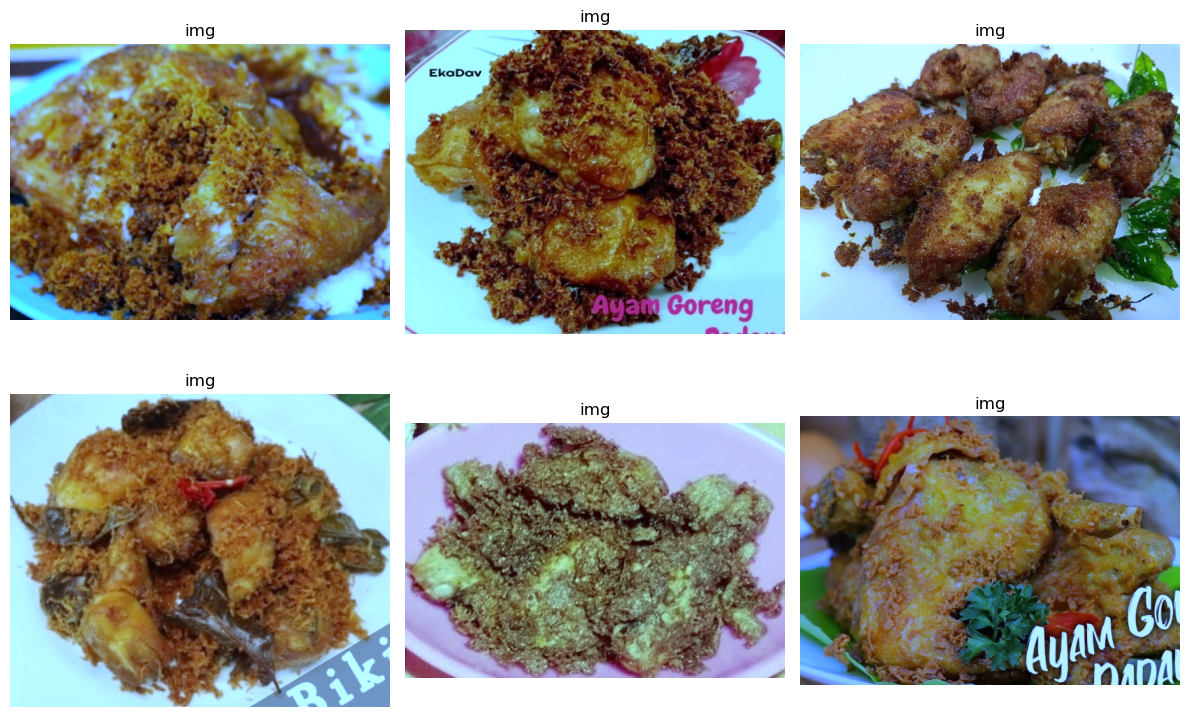

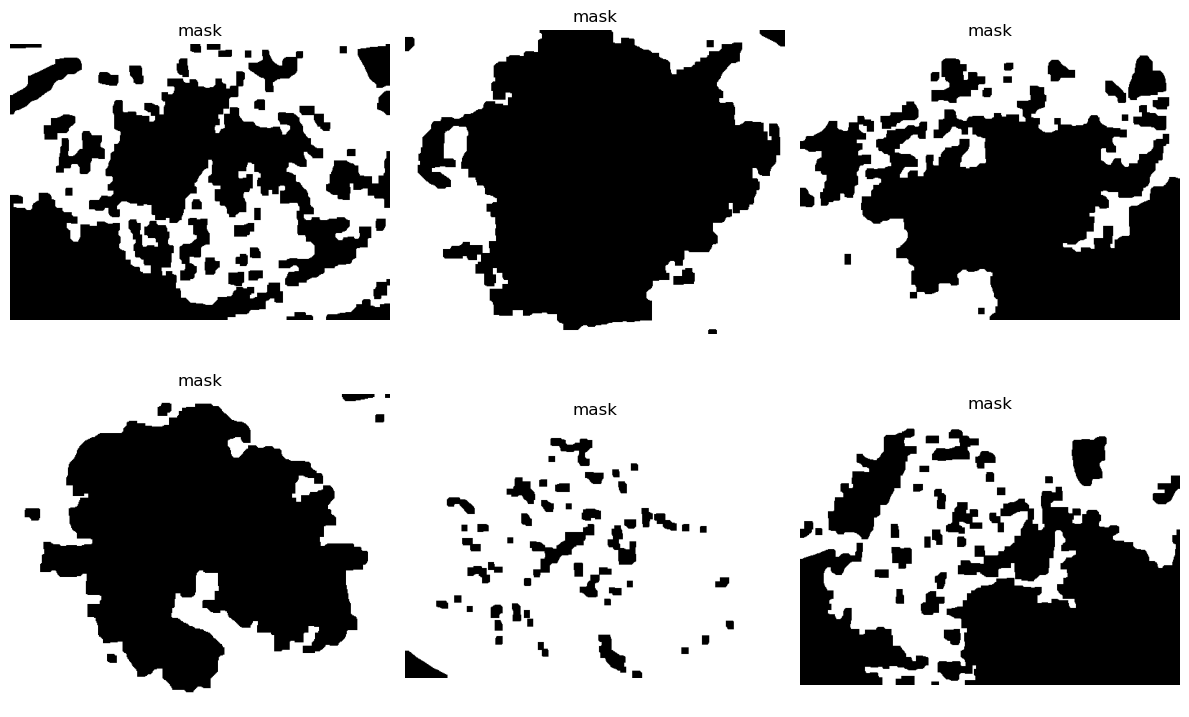

In [21]:
# Bangun dataset fitur
def build_dataset(paths_labels, seg_method=None):
    X = []
    y = []
    for p,yc in tqdm(paths_labels, desc='Extracting', total=len(paths_labels)):
        img = imread_resize(p, target_short=img_size)
        img = gray_world(img)
        mask = None
        if seg_method is not None:
            mask = get_mask(img, method=seg_method)
        feats = extract_features(img, mask)
        X.append(feats)
        y.append(class_to_idx[yc])
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y

# Contoh preview segmentasi pada beberapa gambar
preview_imgs = []
preview_masks = []
for p,_ in all_paths[:min(6,len(all_paths))]:
    img = imread_resize(p, target_short=img_size)
    img_cc = gray_world(img)
    m = get_mask(img_cc, method=segmentation_method) if use_segmentation else np.ones(img_cc.shape[:2], dtype=np.uint8)
    preview_imgs.append(img_cc)
    preview_masks.append(m*255)
show_imgs(preview_imgs, cols=3, titles=['img']*len(preview_imgs))
show_imgs([cv2.cvtColor(m, cv2.COLOR_GRAY2BGR) for m in preview_masks], cols=3, titles=['mask']*len(preview_masks))


In [22]:
# Pelatihan & evaluasi
def make_pipeline(do_pca=True, pca_var=0.95):
    steps = [('scaler', StandardScaler())]
    if do_pca:
        steps.append(('pca', PCA(n_components=pca_var, svd_solver='full')))
    steps.append(('svc', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=random_state)))
    return Pipeline(steps)

def train_eval(X, y, test_size=0.2, cv_folds=5, do_pca=True, pca_var=0.95):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    pipe = make_pipeline(do_pca, pca_var)
    param_grid = {
        'svc__C': [1, 10, 100],
        'svc__gamma': ['scale', 0.01, 0.001]
    }
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    grid = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=1)
    grid.fit(X_train, y_train)
    print('Best params:', grid.best_params_)
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    print(f'Holdout Accuracy: {acc:.4f} | Macro F1: {f1m:.4f}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred, target_names=[idx_to_class[i] for i in range(len(classes))]))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    if sns is not None:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    else:
        plt.imshow(cm, cmap='Blues'); plt.colorbar()
        plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
        plt.yticks(range(len(classes)), classes)
        for (i,j),v in np.ndenumerate(cm):
            plt.text(j,i,str(v),ha='center',va='center')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
    plt.tight_layout(); plt.show()
    return best, (acc, f1m), (X_test, y_test, y_pred)


In [24]:
# Runner ablation
def run_experiment(seg=False, feats=('hsv','moments','lbp','glcm'), do_pca=True):
    global use_segmentation, use_hist_hsv, use_color_moments, use_lbp, use_glcm
    # Simpan state
    prev = (use_segmentation, use_hist_hsv, use_color_moments, use_lbp, use_glcm)
    use_segmentation = seg
    use_hist_hsv = 'hsv' in feats
    use_color_moments = 'moments' in feats
    use_lbp = 'lbp' in feats
    use_glcm = 'glcm' in feats
    print('Config → seg:', seg, '| feats:', feats, '| pca:', do_pca)
    X, y = build_dataset(all_paths, seg_method=segmentation_method if seg else None)
    model, metrics, _ = train_eval(X, y, test_size=test_size, cv_folds=cv_folds, do_pca=do_pca, pca_var=pca_var)
    # Kembalikan state
    use_segmentation, use_hist_hsv, use_color_moments, use_lbp, use_glcm = prev
    return model, metrics

def quick_ablation():
    results = []
    exps = [
        ('A1 warna', dict(seg=False, feats=('hsv','moments'), do_pca=True)),
        ('A2 tekstur', dict(seg=False, feats=('lbp','glcm'), do_pca=True)),
        ('A3 gabungan', dict(seg=False, feats=('hsv','moments','lbp','glcm'), do_pca=True)),
        ('A4 gab+seg', dict(seg=True, feats=('hsv','moments','lbp','glcm'), do_pca=True)),
    ]
    for name, cfg in exps:
        print('='*80)
        print(name)
        _, (acc, f1m) = run_experiment(**cfg)
        results.append((name, acc, f1m))
    print('Ringkasan:')
    for n,a,f in results:
        print(f'{n:12s} → acc={a:.4f}, f1m={f:.4f}')
    return results


Extracting: 100%|██████████| 993/993 [04:53<00:00,  3.38it/s]


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'svc__C': 100, 'svc__gamma': 0.001}
Holdout Accuracy: 0.5678 | Macro F1: 0.5635

Classification Report:
                 precision    recall  f1-score   support

    ayam_goreng       0.43      0.57      0.49        21
       ayam_pop       0.88      0.96      0.92        23
 daging_rendang       0.45      0.62      0.52        21
dendeng_batokok       0.82      0.64      0.72        22
     gulai_ikan       0.57      0.55      0.56        22
  gulai_tambusu       0.44      0.38      0.41        21
  gulai_tunjang       0.50      0.58      0.54        24
   telur_balado       0.53      0.36      0.43        22
    telur_dadar       0.56      0.43      0.49        23

       accuracy                           0.57       199
      macro avg       0.58      0.57      0.56       199
   weighted avg       0.58      0.57      0.57       199



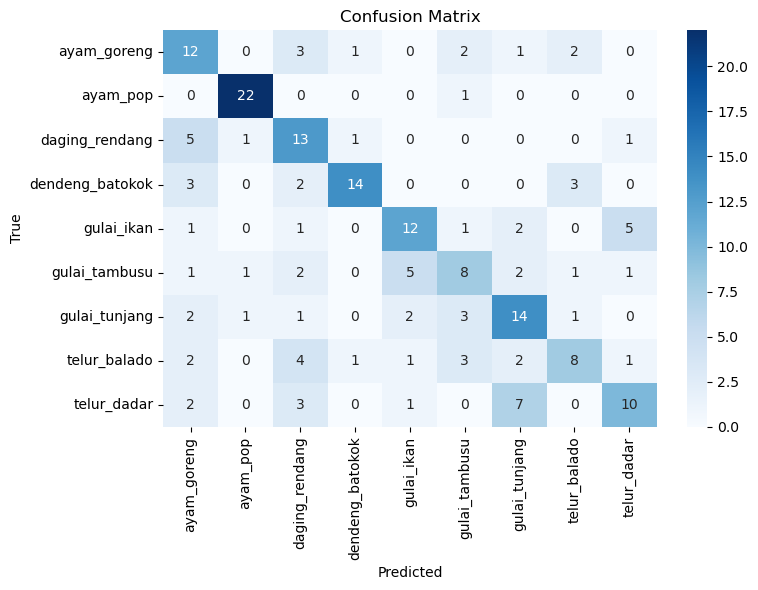

Selesai baseline. Metrics: (0.5678391959798995, 0.5635006774517348)


In [25]:
# Jalankan baseline sesuai konfigurasi atas
if use_segmentation:
    X, y = build_dataset(all_paths, seg_method=segmentation_method)
else:
    X, y = build_dataset(all_paths, seg_method=None)
model, metrics, eval_pack = train_eval(X, y, test_size=test_size, cv_folds=cv_folds, do_pca=use_pca, pca_var=pca_var)
print('Selesai baseline. Metrics:', metrics)
